# Application Serving Pipeline

This notebook demonstrate how to serve standard ML/DL models using **MLRun Serving**.

Make sure you went over the basics in MLRun [**Quick Start Tutorial**](./01-mlrun-basics.html).


MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source "serverless" framework that's focused on data, I/O, and compute-intensive workloads.


MLRun serving supports advanced real-time data processing and model serving pipelines.<br>
For more details and examples, see the {ref}`MLRun serving pipelines <serving>` documentation.

Tutorial steps:
- [**Create, test and build advanced model Serving Graph**](#serving-function)
- [**Deploy the serving Function**](#deploy-serving)

In [ ]:
%pip install -r requirements.txt

<a id="define-project"></a>
## Define MLRun project and set all mlrun function

You should create, load, or use (get) an **{ref}`MLRun Project <Projects>`** that holds all your functions and assets ([setup.py](./src/setup.py))


In [1]:
import mlrun
from src.setup import create_and_set_project

project = create_and_set_project(name="huggingface-demo")

> 2023-02-15 08:47:30,829 [warning] Failed resolving version info. Ignoring and using defaults
> 2023-02-15 08:47:33,638 [warning] Server or client version is unstable. Assuming compatible: {'server_version': '1.3.0-rc22', 'client_version': '0.0.0+unstable'}
> 2023-02-15 08:47:49,698 [info] loaded project huggingface-demo from ./ and saved in MLRun DB


Names with underscore '_' are about to be deprecated, use dashes '-' instead.Replacing underscores with dashes.


<a id="serving-function"></a>
## Create and test the Serving Function

The serving function is consisted of preprocess functions that transfers the text input into a request for the serving function, and the postprocess function passes the model output into the gradio interface. 

See the functions in [here](./src/serving.py)

In [2]:
serving_function = mlrun.code_to_function(
    filename="src/onnx_model_server.py",
    name="serving",
    kind="serving", 
    image="davesh0812/mlrun:mlrun-huggingface-demo-1",
)

### Defining our serving graph

Setting the serving graph topology with the step order

In [3]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

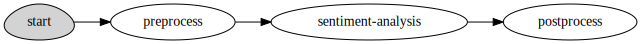

In [4]:
# Build the serving graph:
graph.to(handler="preprocess", name="preprocess")\
     .to("mlrun.frameworks.huggingface.HuggingFaceModelServer",
          name="sentiment-analysis",
          task="sentiment-analysis",
          model_name="distilbert-base-uncased",
          model_class="AutoModelForSequenceClassification",
          tokenizer_name="distilbert-base-uncased",
          tokenizer_class="AutoTokenizer")\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

In [5]:
# registering the serving 
project.set_function(serving_function)
project.save()

### Simulate the application pipeline locally

Creating a mocking server for testing

In [6]:
server = serving_function.to_mock_server()
server.test(path='/predict', body= "i love flying")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

> 2023-02-15 08:48:04,160 [info] model sentiment-analysis was loaded


['The sentiment is POSITIVE', 'The prediction score is 0.5397533774375916']

<a id="deploy-serving"></a>
## Deploy the serving Function

In [7]:
deployment = project.deploy_function(serving_function)

> 2023-02-15 08:48:04,203 [info] Starting remote function deploy
2023-02-15 08:48:04  (info) Deploying function
2023-02-15 08:48:04  (info) Building
2023-02-15 08:48:04  (info) Staging files and preparing base images
2023-02-15 08:48:04  (info) Building processor image
2023-02-15 08:50:40  (info) Build complete
2023-02-15 08:51:38  (info) Function deploy complete
> 2023-02-15 08:51:38,291 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-huggingface-demo-davids-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['huggingface-demo-davids-serving-huggingface-demo-davids.default-tenant.app.cto-office.iguazio-cd1.com/']}


### Gradio front-end

Gradio is a friendly web interface that we demonstrate here how to use easily for submitting predictions to our real-time pipeline and to get the results as well!

For more information, please see [gradio page](https://gradio.app/)

After running this sell try to insert 'i love flying' and see the result

In [8]:
from src.gradio_front import build_and_launch

build_and_launch(url=deployment.outputs['endpoint'])

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://732e981d-0259-440a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
